# Man vs Woman

In [1]:
import numpy as np
from matplotlib import pyplot as pl
import os
import scipy.io.wavfile as wav
from python_speech_features import mfcc
import utils.mlp_backprop_momentum as mlp
import utils.k_fold_cross_validation as cv

%matplotlib inline

# Dataset

In [2]:
PATH = 'vowels/'

MALE = [1,-1]
FEMALE = [-1,1]

In [3]:
mfccs = []

for filename in os.listdir(PATH):
    if filename.endswith('.wav'):
        sample_rate, X = wav.read(os.path.join(PATH, filename))
        ceps = np.mean(mfcc(X, samplerate=sample_rate, nfft=1024), axis=0)
        
        if filename.startswith('nam'):
            speaker = MALE
        elif filename.startswith('naf'):
            speaker = FEMALE
        else:
            continue
            
        ceps = np.append(ceps, speaker)
        mfccs.append(ceps)
        
mfccs = np.array(mfccs)
mfccs = mfccs - mfccs.min(axis=0)
mfccs = mfccs / mfccs.max(axis=0)
mfccs = mfccs * 2 - 1


In [4]:
mfccs

array([[ 0.76553545, -0.75047923, -0.58390145, ...,  0.40026027,
         1.        , -1.        ],
       [-0.25131387,  0.1452556 , -0.57393645, ..., -0.25075574,
         1.        , -1.        ],
       [ 0.02371591, -0.09275748,  0.017289  , ...,  0.08563128,
        -1.        ,  1.        ],
       ...,
       [-0.64084113,  0.44619141,  0.23240784, ...,  1.        ,
         1.        , -1.        ],
       [ 0.16321835,  0.06977536, -0.47658137, ..., -0.10825736,
         1.        , -1.        ],
       [ 0.33764801, -0.39301573, -0.61665482, ...,  0.27252173,
         1.        , -1.        ]])

# Exploring the number of epochs¶

In [29]:
# learning 

dataset = mfccs
N_INITS = 10
EPOCHS = 200 #nb d'iterations
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.005
MOMENTUM = 0.5
K=5

In [22]:
MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,2], 'tanh')
    for i in np.arange(N_INITS):                                        # looping the initializations
        nn.init_weights()
        
        MSE[i_h, i, :] = nn.fit((dataset[:,0:13], dataset[:,13:15]),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

Testing 2 neurons...


KeyboardInterrupt: 

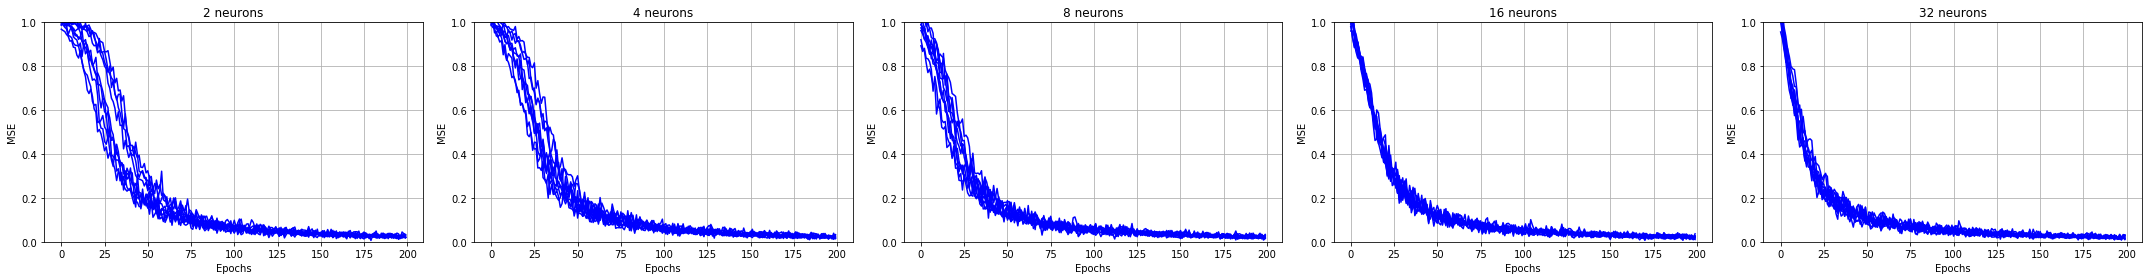

In [109]:
pl.figure(figsize=(30,4))
p_count = 0
for n in np.arange(MSE.shape[0]):
    pl.subplot(1, MSE.shape[0], n+1)
    for i in np.arange(MSE.shape[1]):
        pl.plot(MSE[n,i,:], c='b')
    pl.ylim(0,1)
    pl.xlabel('Epochs')
    pl.ylabel('MSE')
    pl.title(str(N_NEURONS[n]) + ' neurons')
    pl.grid()
pl.tight_layout()

# Exploring the number of hidden neurons

In [32]:
EPOCHS = 150
K = 5
N_TESTS = 10
N_NEURONS = [2, 4, 6, 8, 10]

In [33]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,2], 'tanh')
    for i in np.arange(N_TESTS):                                        # looping the tests
        nn.init_weights()                                               # the network has to be reinitialized before each test
        temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,         # notice that we do not use cv.k_fold_cross_validation
                                                            dataset,    # but cv.k_fold_cross_validation_per_epoch which
                                                            k=K,        # returns a value of error per each epoch
                                                            learning_rate=LEARNING_RATE,
                                                            momentum=MOMENTUM,
                                                            epochs=EPOCHS)
        # temp1 and temp2 are the training and test error. One value per epoch
        MSE_train[i_h, :, i] = temp1
        MSE_test[i_h, :, i] = temp2

Testing 2 neurons...
Testing 4 neurons...
Testing 6 neurons...
Testing 8 neurons...
Testing 10 neurons...


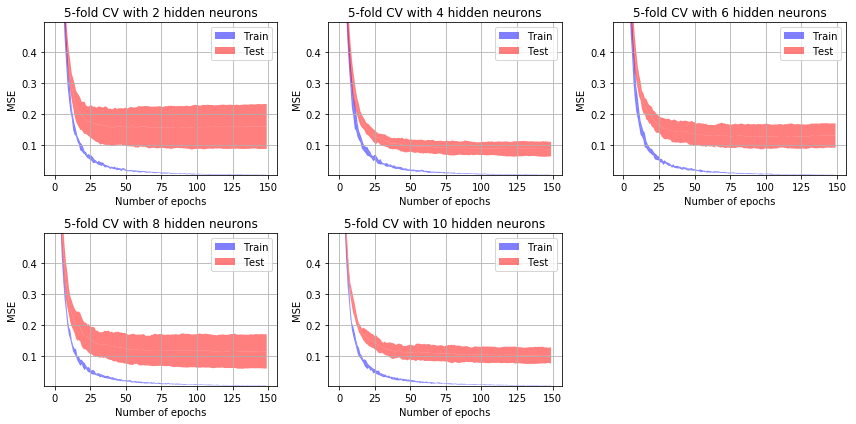

In [34]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,0.5*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

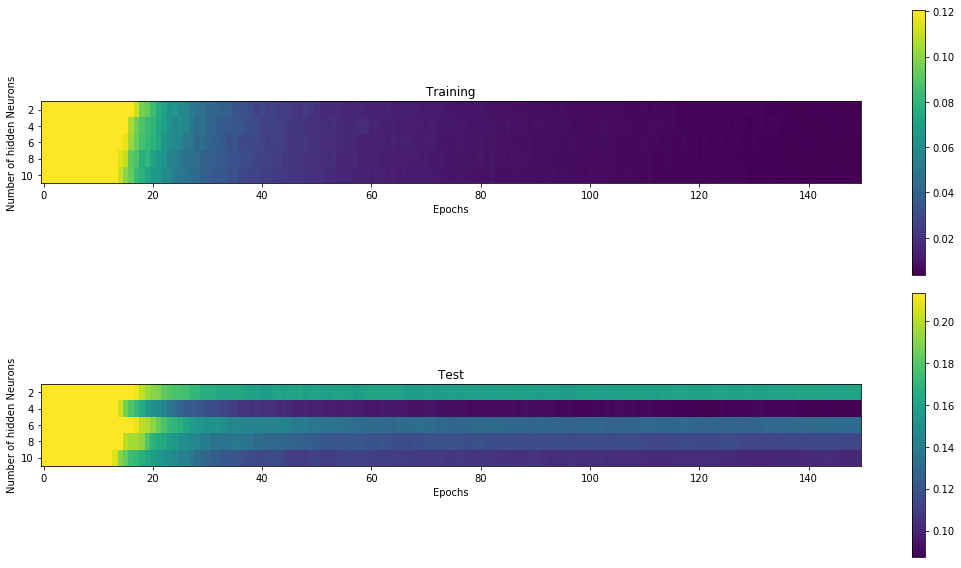

In [35]:
pl.figure(figsize=(15,8))
pl.subplot(2,1,1)
pl.imshow(MSE_train_mean, vmin=np.min(MSE_train_mean), vmax=np.percentile(MSE_train_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2,1,2)
pl.imshow(MSE_test_mean, vmin=np.min(MSE_test_mean), vmax=np.percentile(MSE_test_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

# Final model

In [48]:
nn = mlp.MLP([13,4,2], 'tanh')

In [49]:
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          dataset,
                                                          k=K,
                                                          learning_rate=LEARNING_RATE,
                                                          momentum=MOMENTUM,
                                                          epochs=40,
                                                          threshold=0.0)
TP = np.diag(conf_mat)
FP = np.sum(conf_mat, axis=0) - TP
FN = np.sum(conf_mat, axis=1) - TP
precision = np.mean(TP/(TP+FP))
recall = np.mean(TP/(TP+FN))

In [50]:
print('MSE training: ', MSE_train)
print('MSE test: ', MSE_test)
print('Confusion matrix:')
print(conf_mat)
print('F1_score : ' + str(2*precision*recall/(precision + recall)))

MSE training:  0.02896517371042536
MSE test:  0.11776085477447147
Confusion matrix:
[[36.  0.]
 [ 3. 34.]]
F1_score : 0.9604978354978355
